In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
import lightgbm as lgb
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest
from joblib import dump

In [78]:
traffic_data = pd.read_csv('traffic_data_ALL_features.csv')
traffic_data['datetime'] = pd.to_datetime(traffic_data['datetime'], format='%Y-%m-%d %H:%M:%S')
traffic_data

datetime grid_id  estimated_traffic  G1辅路  G4辅路  G6辅路  一经路  \
0      2008-02-02 13:30:00    10_1                 65     0     0     0    0   
1      2008-02-02 13:30:00   10_10              33995     0     0     1    0   
2      2008-02-02 13:30:00   10_11               2730     0     0     1    0   
3      2008-02-02 13:30:00   10_12                780     0     0     0    0   
4      2008-02-02 13:30:00   10_13                260     0     0     0    0   
...                    ...     ...                ...   ...   ...   ...  ...   
173451 2008-02-08 17:30:00    5_13                195     0     0     0    0   
173452 2008-02-08 17:30:00   19_19                260     0     0     0    0   
173453 2008-02-08 17:30:00   19_20                650     0     0     0    0   
173454 2008-02-08 17:30:00    3_14                  0     0     0     0    0   
173455 2008-02-08 17:30:00    3_11                 65     0     0     0    0   

        七星路  万丰路  万华街  ...  is_weekend  quarter  day_of_month  week_of_year  \
0         0    0    0  ...           1        1             2             5   
1         0    0    0  ...           1        1             2             5   
2         0    0    0  ...           1        1             2             5   
3         0    0    0  ...           1        1             2             5   
4         0    0    0  ...           1        1             2             5   
...     ...  ...  ...  ...         ...      ...           ...           ...   
173451    0    0    0  ...           0        1             8             6   
173452    0    0    0  ...           0        1             8             6   
173453    0    0    0  ...           0        1             8             6   
173454    0    0    0  ...           0        1             8             6   
173455    0    0    0  ...           0        1             8             6   

        hour_sin  hour_cos  day_of_week_sin  day_of_week_cos  \
0      -0.258819 -0.965926        -0.974928        -0.222521   
1      -0.258819 -0.965926        -0.974928        -0.222521   
2      -0.258819 -0.965926        -0.974928        -0.222521   
3      -0.258819 -0.965926        -0.974928        -0.222521   
4      -0.258819 -0.965926        -0.974928        -0.222521   
...          ...       ...              ...              ...   
173451 -0.965926 -0.258819        -0.433884        -0.900969   
173452 -0.965926 -0.258819        -0.433884        -0.900969   
173453 -0.965926 -0.258819        -0.433884        -0.900969   
173454 -0.965926 -0.258819        -0.433884        -0.900969   
173455 -0.965926 -0.258819        -0.433884        -0.900969   

        day_of_month_sin  day_of_month_cos  
0               0.394356          0.918958  
1               0.394356          0.918958  
2               0.394356          0.918958  
3               0.394356          0.918958  
4               0.394356          0.918958  
...                  ...               ...  
173451          0.998717         -0.050649  
173452          0.998717         -0.050649  
173453          0.998717         -0.050649  
173454          0.998717         -0.050649  
173455          0.998717         -0.050649  

[173456 rows x 1248 columns]

In [79]:
categorial_features = traffic_data.select_dtypes(include=['object', 'category']).columns.tolist()
categorial_features

['grid_id',
 'neighbor_top_left',
 'neighbor_top',
 'neighbor_top_right',
 'neighbor_right',
 'neighbor_bottom_right',
 'neighbor_bottom',
 'neighbor_bottom_left',
 'neighbor_left']

In [80]:
def mean_target_encoding(df, target, categorical_features):
    df_encoded = df.copy()
    split_idx = int(0.8 * len(df_encoded))
    train = df_encoded.iloc[:split_idx].copy()
    test = df_encoded.iloc[split_idx:].copy()
    global_mean = round(train[target].mean(), 2)
    mappings = {}

    for feature in categorical_features:
        means = train.groupby(feature)[target].mean().round(2)  # Round means to 2 decimals
        train[feature] = train[feature].map(means)
        test[feature] = test[feature].map(means).fillna(global_mean)
        # Store mapping for inverse transform
        mappings[feature] = means.to_dict()
        # Also store the inverse mapping (mean -> category)
        mappings[f"{feature}_inverse"] = {v: k for k, v in means.to_dict().items()}

    encoded_df = pd.concat([train, test], axis=0)
    return encoded_df.sort_index(), mappings

In [81]:
traffic_data = traffic_data.sort_values('datetime')
traffic_data_mte = traffic_data.copy()
traffic_data_mte, mappings = mean_target_encoding(traffic_data_mte, 'estimated_traffic', categorial_features)
traffic_data_mte = traffic_data_mte.sort_values('datetime')
traffic_data_mte

datetime   grid_id  estimated_traffic  G1辅路  G4辅路  G6辅路  \
0      2008-02-02 13:30:00     55.66                 65     0     0     0   
199    2008-02-02 13:30:00  21007.20              33345     0     0     0   
198    2008-02-02 13:30:00    145.22                195     0     0     0   
197    2008-02-02 13:30:00  12524.16              15275     0     0     0   
196    2008-02-02 13:30:00   9788.12               9685     0     1     0   
...                    ...       ...                ...   ...   ...   ...   
173257 2008-02-08 17:30:00    232.24                 65     0     0     0   
173256 2008-02-08 17:30:00    187.58                260     0     0     0   
173255 2008-02-08 17:30:00    150.34                260     0     0     0   
173271 2008-02-08 17:30:00    270.44                325     0     0     0   
173455 2008-02-08 17:30:00     55.13                 65     0     0     0   

        一经路  七星路  万丰路  万华街  ...  is_weekend  quarter  day_of_month  \
0         0    0    0    0  ...           1        1             2   
199       0    0    0    0  ...           1        1             2   
198       0    0    0    0  ...           1        1             2   
197       0    0    0    0  ...           1        1             2   
196       0    0    1    0  ...           1        1             2   
...     ...  ...  ...  ...  ...         ...      ...           ...   
173257    0    0    0    0  ...           0        1             8   
173256    0    0    0    0  ...           0        1             8   
173255    0    0    0    0  ...           0        1             8   
173271    0    0    0    0  ...           0        1             8   
173455    0    0    0    0  ...           0        1             8   

        week_of_year  hour_sin  hour_cos  day_of_week_sin  day_of_week_cos  \
0                  5 -0.258819 -0.965926        -0.974928        -0.222521   
199                5 -0.258819 -0.965926        -0.974928        -0.222521   
198                5 -0.258819 -0.965926        -0.974928        -0.222521   
197                5 -0.258819 -0.965926        -0.974928        -0.222521   
196                5 -0.258819 -0.965926        -0.974928        -0.222521   
...              ...       ...       ...              ...              ...   
173257             6 -0.965926 -0.258819        -0.433884        -0.900969   
173256             6 -0.965926 -0.258819        -0.433884        -0.900969   
173255             6 -0.965926 -0.258819        -0.433884        -0.900969   
173271             6 -0.965926 -0.258819        -0.433884        -0.900969   
173455             6 -0.965926 -0.258819        -0.433884        -0.900969   

        day_of_month_sin  day_of_month_cos  
0               0.394356          0.918958  
199             0.394356          0.918958  
198             0.394356          0.918958  
197             0.394356          0.918958  
196             0.394356          0.918958  
...                  ...               ...  
173257          0.998717         -0.050649  
173256          0.998717         -0.050649  
173255          0.998717         -0.050649  
173271          0.998717         -0.050649  
173455          0.998717         -0.050649  

[173456 rows x 1248 columns]

## Train models that do not require categorical encoding (they can do it themselves)

In [98]:
# Train/Val/Test Split
n_total = len(traffic_data)
train = traffic_data.iloc[:int(n_total * 0.8)]
val = traffic_data.iloc[int(n_total * 0.8):int(n_total * 0.9)]
test = traffic_data.iloc[int(n_total * 0.9):]

features = list(traffic_data.columns)
features = [i for i in features if i not in ['datetime', 'estimated_traffic']]

# Prepare Features and Target
features = features
target = 'estimated_traffic'

X_train, y_train = train[features], train[target]
X_val, y_val = val[features], val[target]
X_test, y_test = test[features], test[target]

In [99]:
np.random.seed(42)
selected_grids = np.random.choice(traffic_data['grid_id'].unique(), 30)
selected_grids

array(['21_12', '16_10', '3_6', '16_12', '10_7', '13_3', '21_12', '19_14',
       '11_5', '14_17', '1_7', '13_7', '18_12', '13_9', '21_13', '11_11',
       '17_14', '12_9', '12_15', '23_14', '19_4', '4_4', '7_13', '15_17',
       '10_8', '16_10', '10_6', '15_11', '4_10', '5_9'], dtype=object)

In [100]:
assert X_train.shape[0] == y_train.shape[0]
assert X_val.shape[0] == y_val.shape[0]
assert X_test.shape[0] == y_test.shape[0]
assert len(X_train) + len(X_val) + len(X_test) == len(traffic_data)

**Models to be checked:**

+ Random Forest - too computationally inefficient

+ LightGBM - evaluated, best of these three

+ CatBoost - evaluated

In [101]:
def evaluate_model(model, X_test=X_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    # for mape filter out the traffic less than 65 (5th percentile) so that the results are more meaningful
    combined = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
    combined = combined[combined['y_test'] > combined['y_test'].quantile(0.05)] # this quantile is around 65 in terms of the traffic
    mape = np.mean(np.abs((combined['y_test'] - combined['y_pred']) / combined['y_test'])) * 100
    print(f"Test Set Performance:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2: {r2:.2f}")
    print(f"MAPE: {mape:.2f}%")
    return mae, rmse, r2, mape

In [102]:
def plot_evaluation(model, X_test=X_test):
    y_pred = model.predict(X_test)
    test_results = test[['datetime', 'grid_id', 'estimated_traffic']].copy()
    test_results['predicted'] = y_pred
    plt.figure(figsize=(20, 75))
    for i, grid_id in enumerate(selected_grids, 1):
        grid_data = test_results[test_results['grid_id'] == grid_id]
        
        plt.subplot(15, 2, i)
        plt.plot(grid_data['datetime'], grid_data['estimated_traffic'], label='Actual', marker='o')
        plt.plot(grid_data['datetime'], grid_data['predicted'], label='Predicted', linestyle='--', marker='x')
        plt.title(f'Grid {grid_id} Traffic - Actual vs Predicted')
        plt.xlabel('Datetime')
        plt.ylabel('Estimated Traffic')
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

### CatBoost

In [16]:
# Train Model
catboost = CatBoostRegressor(
    cat_features=categorial_features,
    random_seed=42,
    verbose=0
)
catboost.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=10, early_stopping_rounds=50)

Learning rate set to 0.110467
0:	learn: 5449.8345517	test: 3418.6063277	best: 3418.6063277 (0)	total: 101ms	remaining: 1m 40s
10:	learn: 1891.8320754	test: 1135.8996551	best: 1135.8996551 (10)	total: 579ms	remaining: 52.1s
20:	learn: 811.5517812	test: 513.7998510	best: 513.7998510 (20)	total: 1.05s	remaining: 49.1s
30:	learn: 546.3655429	test: 415.6034231	best: 415.6034231 (30)	total: 1.53s	remaining: 48s
40:	learn: 484.3868068	test: 409.8489847	best: 409.8489847 (40)	total: 2.02s	remaining: 47.1s
50:	learn: 459.6792892	test: 407.7773646	best: 407.5045780 (48)	total: 2.49s	remaining: 46.3s
60:	learn: 448.1059666	test: 406.6747309	best: 406.6747309 (60)	total: 2.98s	remaining: 45.9s
70:	learn: 441.0537569	test: 405.9642941	best: 405.9642941 (70)	total: 3.48s	remaining: 45.6s
80:	learn: 434.5400119	test: 405.3934991	best: 404.8537307 (74)	total: 3.96s	remaining: 44.9s
90:	learn: 428.1256577	test: 404.7118303	best: 404.7118303 (90)	total: 4.43s	remaining: 44.3s
100:	learn: 422.9785224	tes

In [17]:
mae_catboost, rmse_catboost, r2_catboost, mape_catboost = evaluate_model(catboost)

Test Set Performance:
MAE: 145.72
RMSE: 323.33
R2: 0.99
MAPE: 17.06%


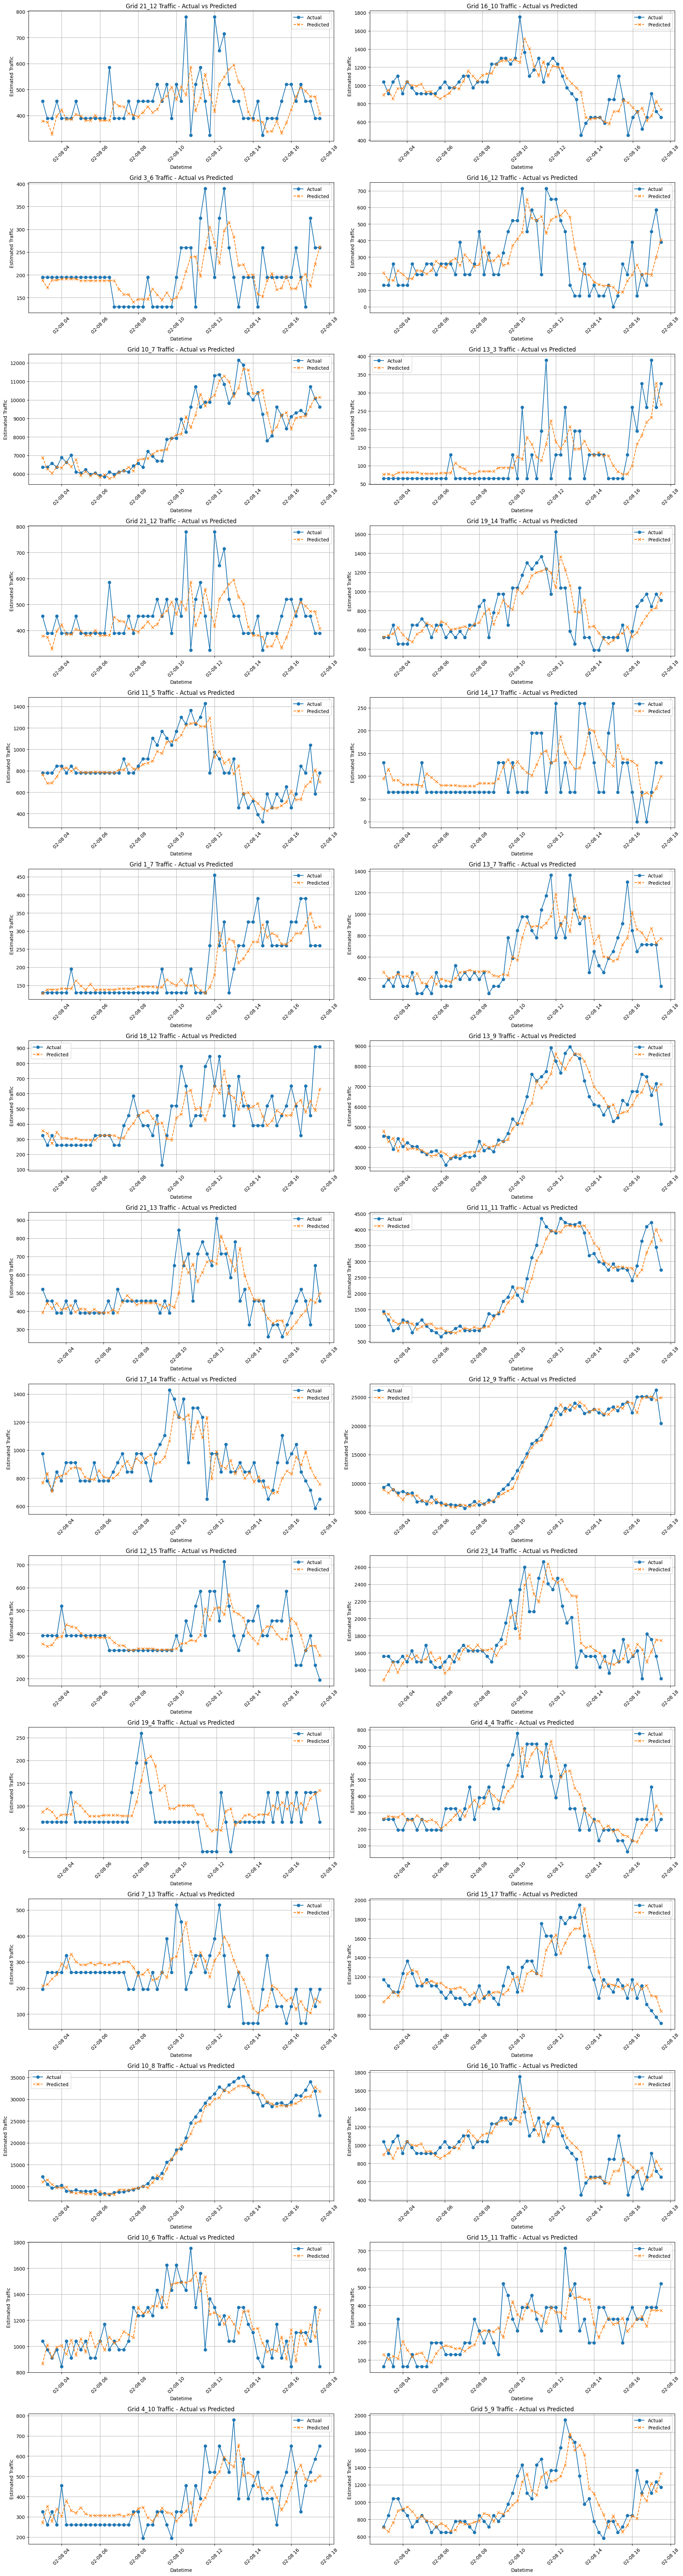

In [27]:
plot_evaluation(catboost)

In [28]:
catboost.save_model("CatBoost_final.cbm")

### LightGBM

In [103]:
X_train_lgb = X_train.copy()
X_val_lgb = X_val.copy()
X_test_lgb = X_test.copy()

for col in categorial_features:
    X_train_lgb[col] = X_train_lgb[col].astype('category')
    X_val_lgb[col] = X_val_lgb[col].astype('category')
    X_test_lgb[col] = X_test_lgb[col].astype('category')

In [ ]:
lgbm = lgb.LGBMRegressor(
    random_state=42,
    n_estimators=1000  # Large number, will stop early due to early_stopping_rounds
)

lgbm.fit(
    X_train_lgb, y_train,
    eval_set=[(X_val_lgb, y_val)],
    callbacks=[
        lgb.early_stopping(50),
        lgb.log_evaluation(10)
    ],
    categorical_feature=categorial_features
)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.099866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7615
[LightGBM] [Info] Number of data points in the train set: 138764, number of used features: 1243
[LightGBM] [Info] Start training from score 1912.055072
Training until validation scores don't improve for 50 rounds
[10]	valid_0's l2: 1.89541e+06
[20]	valid_0's l2: 364523
[30]	valid_0's l2: 184881
[40]	valid_0's l2: 164141
[50]	valid_0's l2: 158594
[60]	valid_0's l2: 155307
[70]	valid_0's l2: 154330
[80]	valid_0's l2: 154180
[90]	valid_0's l2: 153744
[100]	valid_0's l2: 153405
[110]	valid_0's l2: 153843
[12

LGBMRegressor(n_estimators=1000, random_state=42)

In [30]:
mae_lgbm, rmse_lgbm, r2_lgbm, mape_lgbm = evaluate_model(lgbm, X_test=X_test_lgb)

Test Set Performance:
MAE: 143.41
RMSE: 320.21
R2: 0.99
MAPE: 16.56%


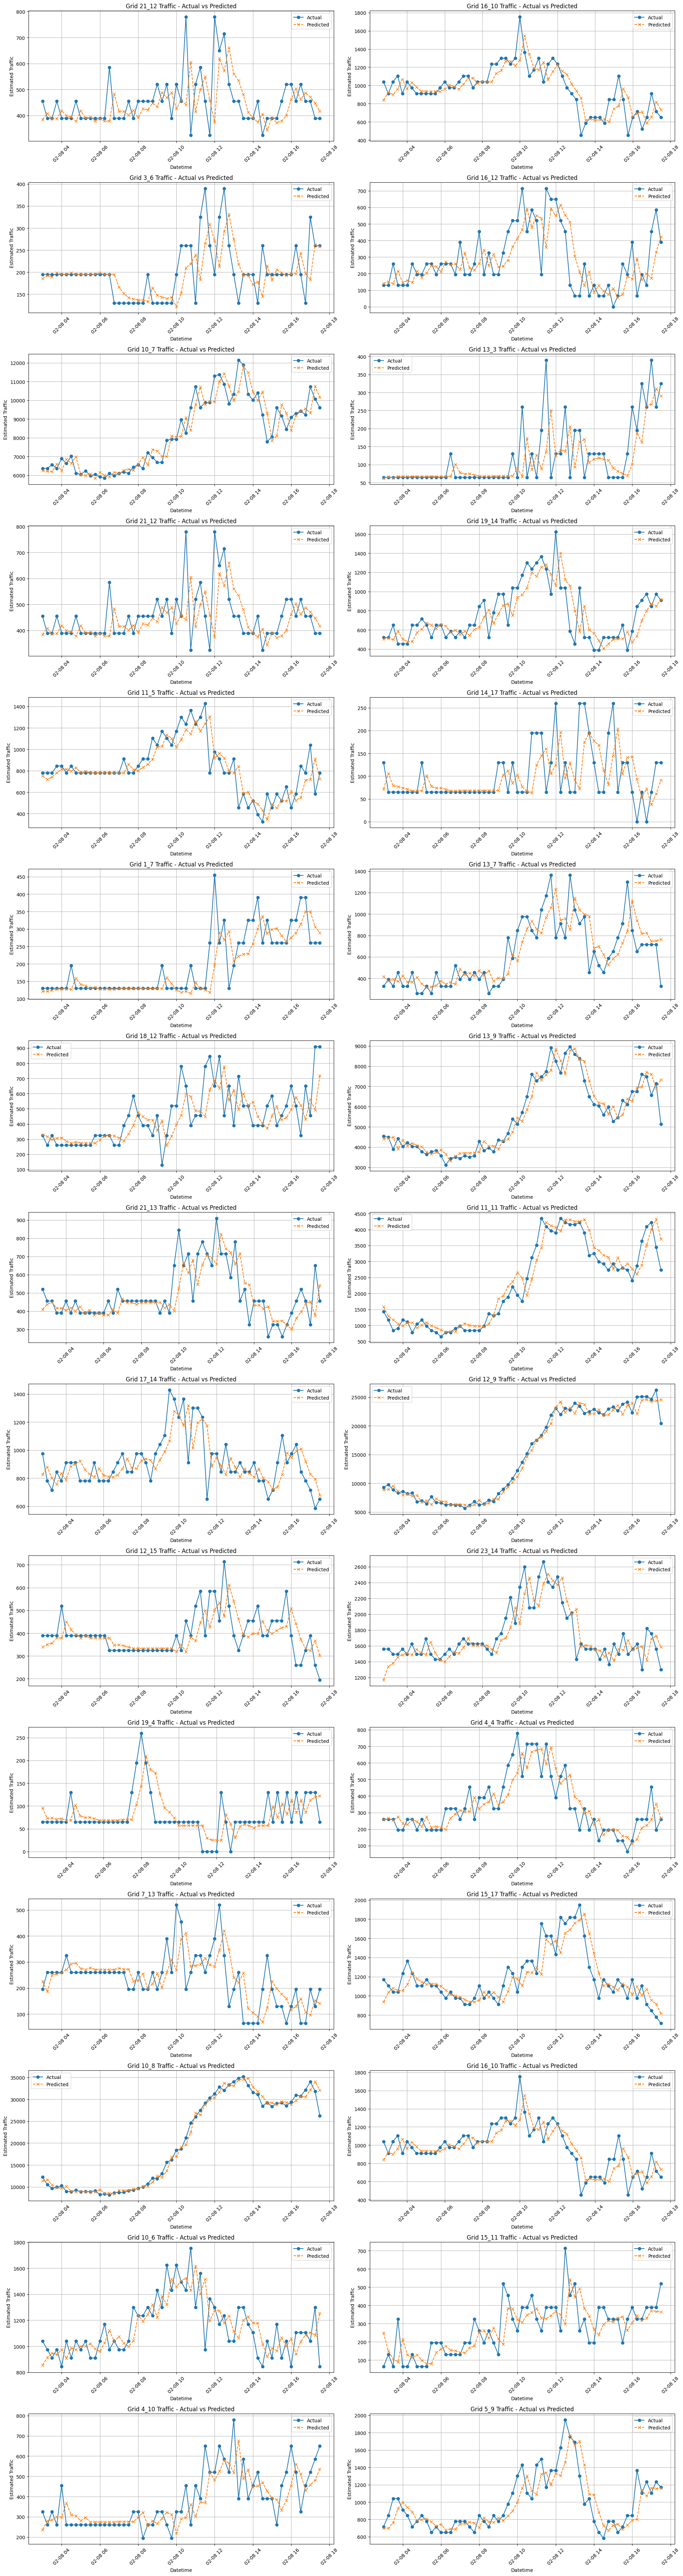

In [31]:
plot_evaluation(lgbm, X_test=X_test_lgb)

In [32]:
lgbm.booster_.save_model("LightGBM_final.txt")

## Train models that require categorical feature encoding

In [85]:
traffic_data_mte

datetime   grid_id  estimated_traffic  G1辅路  G4辅路  G6辅路  \
0      2008-02-02 13:30:00     55.66                 65     0     0     0   
199    2008-02-02 13:30:00  21007.20              33345     0     0     0   
198    2008-02-02 13:30:00    145.22                195     0     0     0   
197    2008-02-02 13:30:00  12524.16              15275     0     0     0   
196    2008-02-02 13:30:00   9788.12               9685     0     1     0   
...                    ...       ...                ...   ...   ...   ...   
173257 2008-02-08 17:30:00    232.24                 65     0     0     0   
173256 2008-02-08 17:30:00    187.58                260     0     0     0   
173255 2008-02-08 17:30:00    150.34                260     0     0     0   
173271 2008-02-08 17:30:00    270.44                325     0     0     0   
173455 2008-02-08 17:30:00     55.13                 65     0     0     0   

        一经路  七星路  万丰路  万华街  ...  is_weekend  quarter  day_of_month  \
0         0    0    0    0  ...           1        1             2   
199       0    0    0    0  ...           1        1             2   
198       0    0    0    0  ...           1        1             2   
197       0    0    0    0  ...           1        1             2   
196       0    0    1    0  ...           1        1             2   
...     ...  ...  ...  ...  ...         ...      ...           ...   
173257    0    0    0    0  ...           0        1             8   
173256    0    0    0    0  ...           0        1             8   
173255    0    0    0    0  ...           0        1             8   
173271    0    0    0    0  ...           0        1             8   
173455    0    0    0    0  ...           0        1             8   

        week_of_year  hour_sin  hour_cos  day_of_week_sin  day_of_week_cos  \
0                  5 -0.258819 -0.965926        -0.974928        -0.222521   
199                5 -0.258819 -0.965926        -0.974928        -0.222521   
198                5 -0.258819 -0.965926        -0.974928        -0.222521   
197                5 -0.258819 -0.965926        -0.974928        -0.222521   
196                5 -0.258819 -0.965926        -0.974928        -0.222521   
...              ...       ...       ...              ...              ...   
173257             6 -0.965926 -0.258819        -0.433884        -0.900969   
173256             6 -0.965926 -0.258819        -0.433884        -0.900969   
173255             6 -0.965926 -0.258819        -0.433884        -0.900969   
173271             6 -0.965926 -0.258819        -0.433884        -0.900969   
173455             6 -0.965926 -0.258819        -0.433884        -0.900969   

        day_of_month_sin  day_of_month_cos  
0               0.394356          0.918958  
199             0.394356          0.918958  
198             0.394356          0.918958  
197             0.394356          0.918958  
196             0.394356          0.918958  
...                  ...               ...  
173257          0.998717         -0.050649  
173256          0.998717         -0.050649  
173255          0.998717         -0.050649  
173271          0.998717         -0.050649  
173455          0.998717         -0.050649  

[173456 rows x 1248 columns]

In [106]:
# Train/Val/Test Split
train = traffic_data_mte.iloc[:int(n_total * 0.8)]
val = traffic_data_mte.iloc[int(n_total * 0.8):int(n_total * 0.9)]
test = traffic_data_mte.iloc[int(n_total * 0.9):]

X_train_new, y_train_new = train[features], train[target]
X_val_new, y_val_new = val[features], val[target]
X_test_new, y_test_new = test[features], test[target]

### XGBoost

In [107]:
# Convert data to DMatrix
dtrain = xgb.DMatrix(X_train_new, label=y_train_new)
dval = xgb.DMatrix(X_val_new, label=y_val_new)
dtest = xgb.DMatrix(X_test_new, label=y_test_new)

In [ ]:
params = {
    'random_state': 42,
}


xgb_model = xgb.train(
    params,
    dtrain,
    evals=[(dval, 'validation')],
    early_stopping_rounds=50,
    verbose_eval=10
)

[0]	validation-rmse:2691.43426
[9]	validation-rmse:421.20073


In [90]:
mae_xgb, rmse_xgb, r2_xgb, mape_xgb = evaluate_model(xgb_model, X_test=dtest)

Test Set Performance:
MAE: 160.52
RMSE: 352.35
R2: 0.99
MAPE: 20.54%


In [91]:
def plot_evaluation_xgb(model, dtest, test=test, selected_grids=selected_grids, mappings=mappings):
    y_pred = model.predict(dtest)
    test_results = test[['datetime', 'grid_id', 'estimated_traffic']].copy()
    test_results['predicted'] = y_pred
    test_results['grid_id'] = test_results['grid_id'].astype(float).map(mappings['grid_id_inverse'])
    plt.figure(figsize=(20, 75))
    for i, grid_id in enumerate(selected_grids, 1):
        # Filter using the original grid_id (not the decoded one)
        grid_data = test_results[test_results['grid_id'] == grid_id]
        # If you want to filter by decoded, use 'grid_id_decoded'
        # grid_data = test_results[test_results['grid_id_decoded'] == grid_id]
        plt.subplot(15, 2, i)
        plt.plot(grid_data['datetime'], grid_data['estimated_traffic'], label='Actual', marker='o')
        plt.plot(grid_data['datetime'], grid_data['predicted'], label='Predicted', linestyle='--', marker='x')
        plt.title(f'Grid {grid_id} Traffic - Actual vs Predicted')
        plt.xlabel('Datetime')
        plt.ylabel('Estimated Traffic')
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

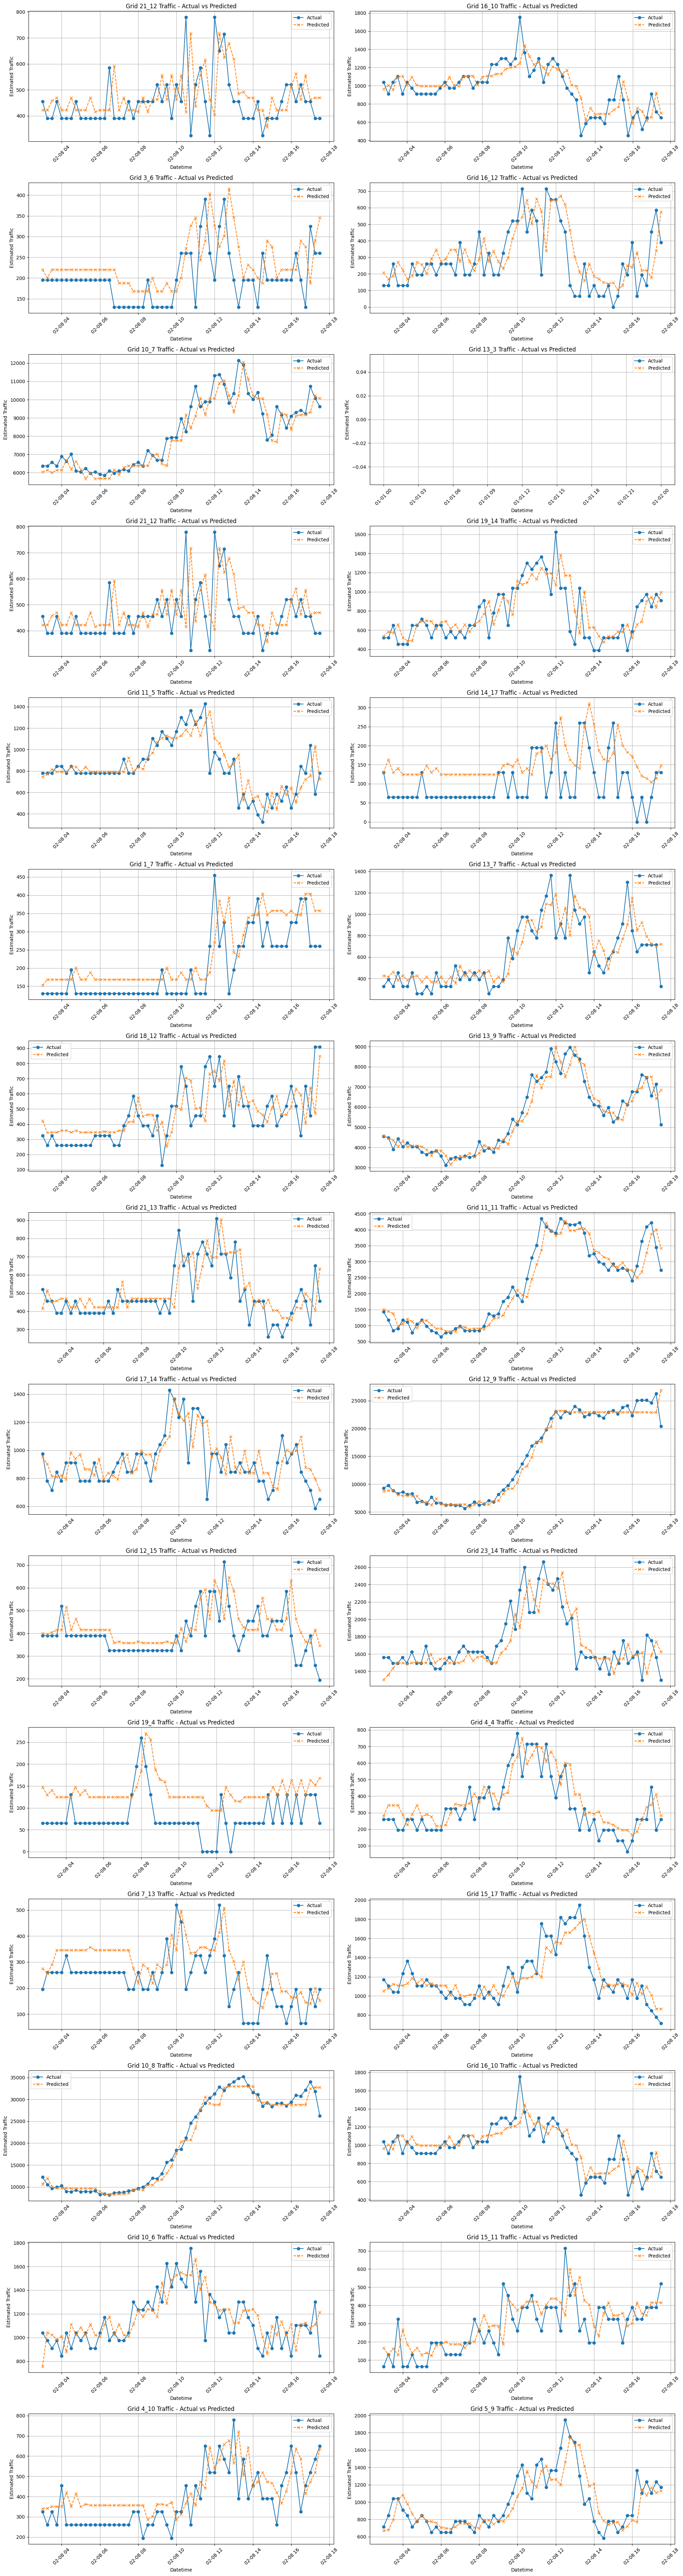

In [92]:
plot_evaluation_xgb(xgb_model, dtest)

In [110]:
xgb_model.save_model("XGBoost_final.json")

### Plot them all

In [116]:
catboost = CatBoostRegressor().load_model('CatBoost_final.cbm')
lgbm = lgb.Booster(model_file='LightGBM_final.txt')
xgboost = xgb.Booster()
xgboost.load_model("XGBoost_final.json")

In [117]:
selected_grids_final_evaluation = ['10_7', '11_11', '10_8']

In [118]:
y_pred_cb = catboost.predict(X_test)
y_pred_lgb = lgbm.predict(X_test_lgb)
y_pred_xgb = xgboost.predict(dtest)

In [120]:
test_results = test[['datetime', 'grid_id', 'estimated_traffic']].copy()
test_results['predicted_cb'] = y_pred_cb
test_results['predicted_lgb'] = y_pred_lgb
test_results['predicted_xgb'] = y_pred_xgb
test_results['grid_id'] = test_results['grid_id'].astype(float).map(mappings['grid_id_inverse'])
test_results = test_results.loc[test_results['grid_id'].isin(selected_grids_final_evaluation)]
test_results

datetime grid_id  estimated_traffic  predicted_cb  \
156181 2008-02-08 03:00:00    10_8              12220  11104.565842   
156180 2008-02-08 03:00:00    10_7               6370   6893.814968   
156184 2008-02-08 03:00:00   11_11               1430   1373.069408   
156474 2008-02-08 03:15:00    10_8              10530  11528.299212   
156473 2008-02-08 03:15:00    10_7               6370   6266.808479   
...                    ...     ...                ...           ...   
172881 2008-02-08 17:15:00    10_7              10075  10113.098569   
172885 2008-02-08 17:15:00   11_11               3445   4001.595850   
173175 2008-02-08 17:30:00    10_8              26260  31825.297566   
173174 2008-02-08 17:30:00    10_7               9620  10148.452944   
173178 2008-02-08 17:30:00   11_11               2730   3663.460697   

        predicted_lgb  predicted_xgb  
156181   11356.507818   10616.733398  
156180    6255.815814    6043.632812  
156184    1579.097242    1521.385986  
156474   11632.499890   12004.036133  
156473    6208.011642    6141.598633  
...               ...            ...  
172881   10742.301133   10221.389648  
172885    4324.656901    3973.074463  
173175   32045.723513   32749.785156  
173174   10167.971859   10069.998047  
173178    3707.946140    3391.603516  

[177 rows x 6 columns]

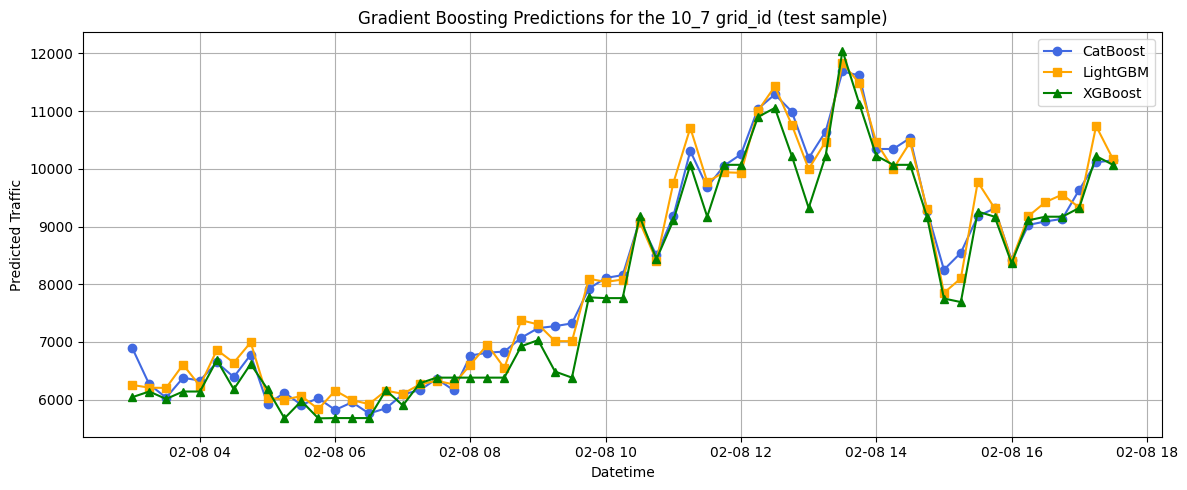

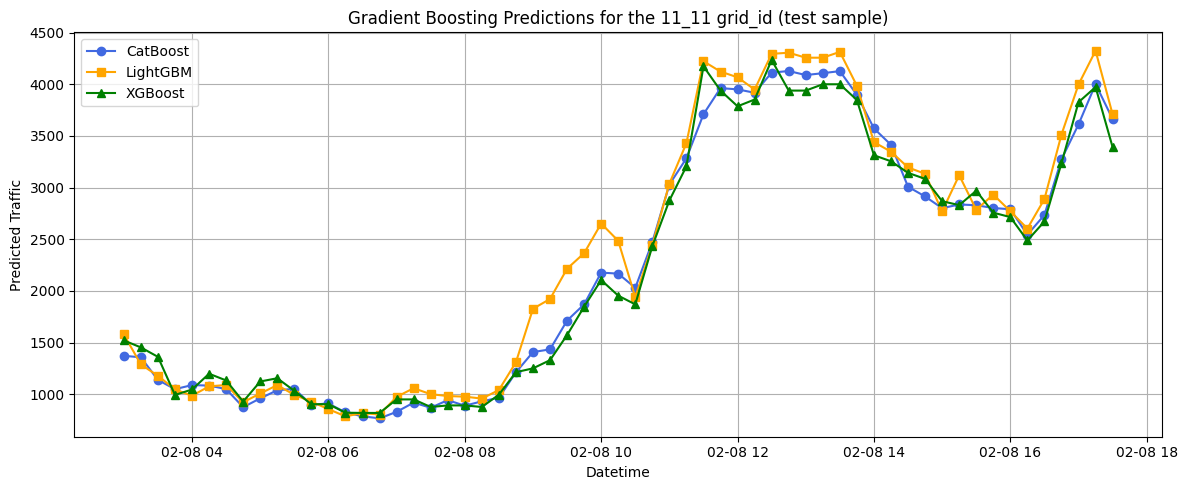

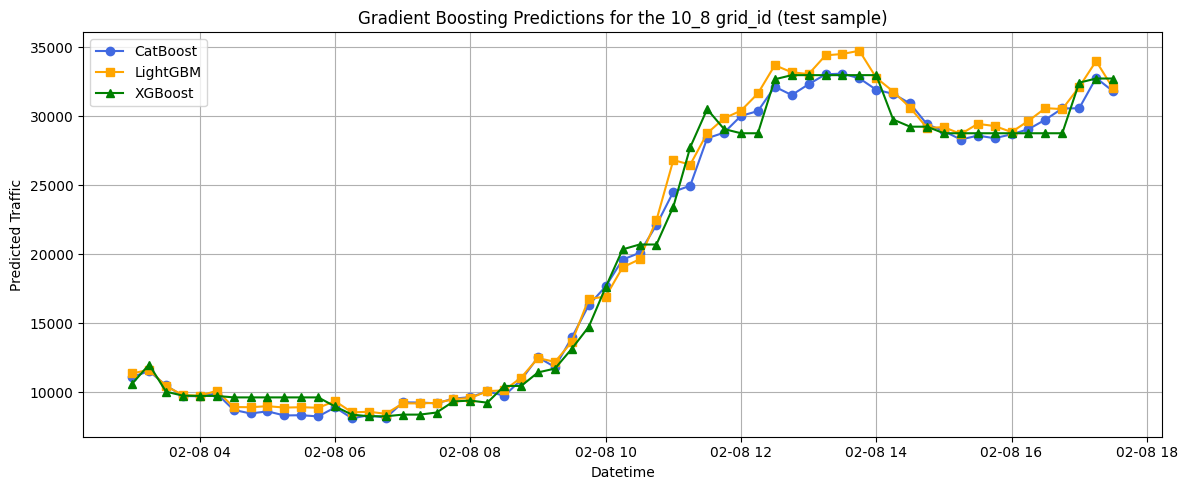

In [121]:
for grid in selected_grids_final_evaluation:
    grid_data = test_results[test_results['grid_id'] == grid]
    plt.figure(figsize=(12, 5))
    plt.plot(grid_data['datetime'], grid_data['predicted_cb'], label='CatBoost', color='royalblue', marker='o')
    plt.plot(grid_data['datetime'], grid_data['predicted_lgb'], label='LightGBM', color='orange', marker='s')
    plt.plot(grid_data['datetime'], grid_data['predicted_xgb'], label='XGBoost', color='green', marker='^')
    plt.xlabel('Datetime')
    plt.ylabel('Predicted Traffic')
    plt.title(f'Gradient Boosting Predictions for the {grid} grid_id (test sample)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'gb_predictions_{grid}.png')
    plt.show()

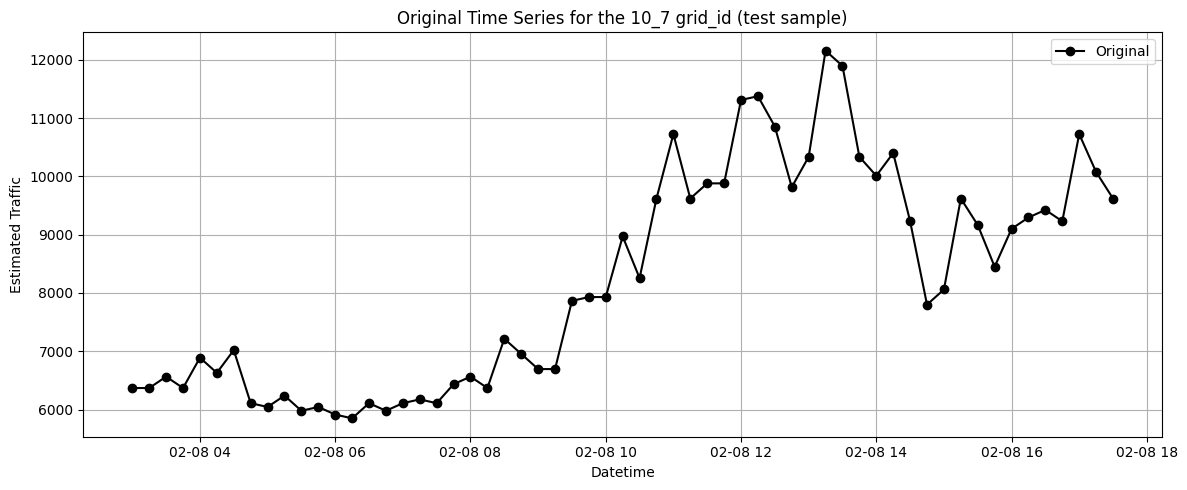

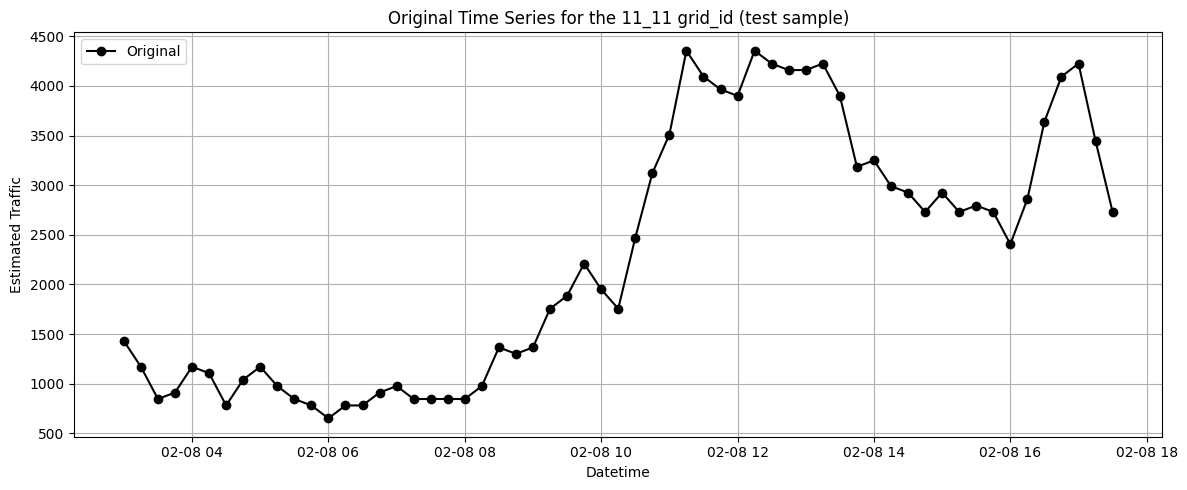

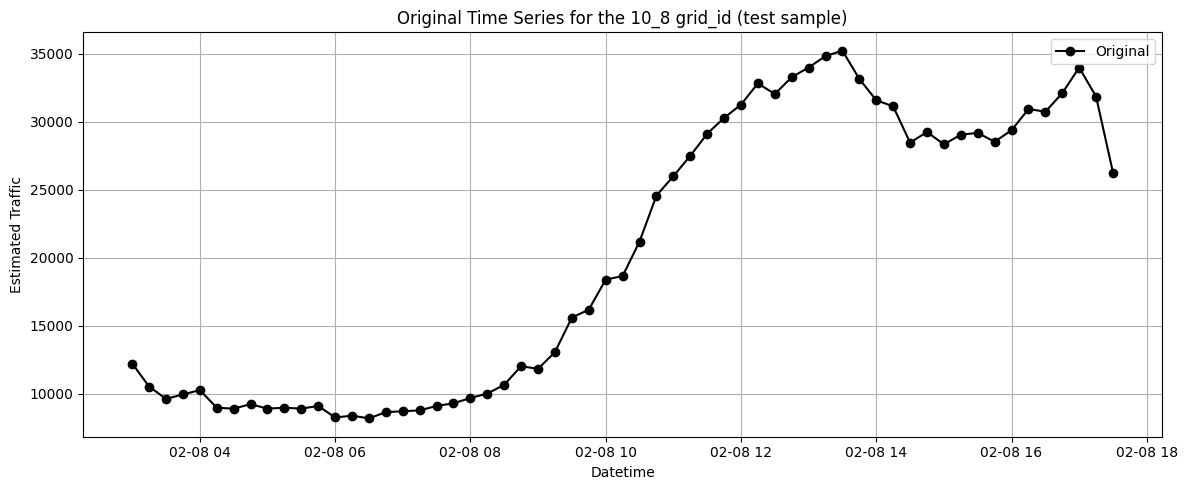

In [122]:
for grid in selected_grids_final_evaluation:
    grid_data = test_results[test_results['grid_id'] == grid]
    plt.figure(figsize=(12, 5))
    plt.plot(grid_data['datetime'], grid_data['estimated_traffic'], label='Original', color='black', marker='o')
    plt.xlabel('Datetime')
    plt.ylabel('Estimated Traffic')
    plt.title(f'Original Time Series for the {grid} grid_id (test sample)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'original_timeseries_{grid}.png')
    plt.show()

## Forecasting

+ measure volatility for every grids

+ volatility distributions

In [9]:
def encode_cyclical(df, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_val)
    return df

In [16]:
np.random.seed(42)
selected_grids = np.random.choice(traffic_data['grid_id'].unique(), 30)
selected_grids

array(['21_12', '16_10', '3_6', '16_12', '10_7', '13_3', '21_12', '19_14',
       '11_5', '14_17', '1_7', '13_7', '18_12', '13_9', '21_13', '11_11',
       '17_14', '12_9', '12_15', '23_14', '19_4', '4_4', '7_13', '15_17',
       '10_8', '16_10', '10_6', '15_11', '4_10', '5_9'], dtype=object)

In [10]:
features = [col for col in traffic_data.columns if col not in ['datetime', 'estimated_traffic']]

In [13]:
grid_features = pd.read_csv('traffic_grid_informations.csv')
grid_features = grid_features.drop(['Unnamed: 0'], axis=1)
grid_features = grid_features.drop(['Unnamed: 0.1'], axis=1)
grid_features

grid_id  G1辅路  G4辅路  G6辅路  一经路  七星路  万丰路  万华街  万寿路  万柳中路  ...  switch  \
0      10_1     0     0     0    0    0    0    0    0     0  ...     1.0   
1     10_10     0     0     1    0    0    0    0    1     0  ...     0.0   
2     10_11     0     0     1    0    0    0    0    0     0  ...     0.0   
3     10_12     0     0     0    0    0    0    0    0     0  ...     8.0   
4     10_13     0     0     0    0    0    0    0    0     0  ...     0.0   
..      ...   ...   ...   ...  ...  ...  ...  ...  ...   ...  ...     ...   
514     9_5     0     0     0    0    0    0    0    0     0  ...    52.0   
515     9_6     0     0     0    0    0    0    0    0     0  ...    15.0   
516     9_7     0     0     0    0    0    0    1    0     0  ...    23.0   
517     9_8     0     1     0    0    0    0    0    0     0  ...   168.0   
518     9_9     0     0     0    0    0    0    0    1     0  ...     6.0   

     traffic_signals  neighbor_top_left  neighbor_top  neighbor_top_right  \
0                0.0                9_2          10_2                11_2   
1              206.0               9_11         10_11               11_11   
2              109.0               9_12         10_12               11_12   
3               28.0               9_13         10_13               11_13   
4                0.0               9_14         10_14               11_14   
..               ...                ...           ...                 ...   
514             35.0                8_6           9_6                10_6   
515             67.0                8_7           9_7                10_7   
516             14.0                8_8           9_8                10_8   
517            146.0                8_9           9_9                10_9   
518            251.0               8_10          9_10               10_10   

     neighbor_right  neighbor_bottom_right  neighbor_bottom  \
0              11_1                     -1               -1   
1             11_10                   11_9             10_9   
2             11_11                  11_10            10_10   
3             11_12                  11_11            10_11   
4             11_13                  11_12            10_12   
..              ...                    ...              ...   
514            10_5                   10_4              9_4   
515            10_6                   10_5              9_5   
516            10_7                   10_6              9_6   
517            10_8                   10_7              9_7   
518            10_9                   10_8              9_8   

     neighbor_bottom_left  neighbor_left  
0                      -1            9_1  
1                     9_9           9_10  
2                    9_10           9_11  
3                    9_11           9_12  
4                    9_12           9_13  
..                    ...            ...  
514                   8_4            8_5  
515                   8_5            8_6  
516                   8_6            8_7  
517                   8_7            8_8  
518                   8_8            8_9  

[519 rows x 1226 columns]

In [23]:
categorial_features = traffic_data.select_dtypes(include=['object', 'category']).columns.tolist()
categorial_features

['grid_id',
 'neighbor_top_left',
 'neighbor_top',
 'neighbor_top_right',
 'neighbor_right',
 'neighbor_bottom_right',
 'neighbor_bottom',
 'neighbor_bottom_left',
 'neighbor_left']

### CatBoost

In [46]:
def forecast_catboost(grid_id, test_set, grid_features, model, features, n_forecast, plot=False):
    """
    Forecast future traffic values for a specific grid_id using the trained CatBoost model.
    
    Parameters:
        grid_id (str/int): Grid ID to forecast.
        test_set (pd.DataFrame): Test dataset with historical data including necessary features.
        grid_features (pd.DataFrame): Features associated with each grid_id.
        model (CatBoostRegressor): Trained CatBoost model.
        features (list): List of feature names used by the model.
        n_forecast (int): Number of steps to forecast (each step is 15 minutes).
        plot (bool): Whether to plot the forecast.
        
    Returns:
        pd.DataFrame: Forecasted values with datetime and estimated_traffic.
    """
    # Filter test_set for the grid_id and get last datetime
    #test_set['datetime'] = pd.to_datetime(test_set['datetime'])
    grid_test = test_set[test_set['grid_id'] == grid_id].sort_values('datetime')
    if grid_test.empty:
        raise ValueError(f"No data found for grid_id {grid_id} in test_set")
    
    last_row = grid_test.iloc[-1]
    last_datetime = last_row['datetime']
    #last_datetime = pd.to_datetime(last_row['datetime'])
    
    # Generate future datetimes (15-minute intervals)
    future_datetimes = pd.date_range(
        start=last_datetime + pd.Timedelta(minutes=15),
        periods=n_forecast,
        freq='15T'
    )
    
    # Create future dataframe
    future = pd.DataFrame({'datetime': future_datetimes, 'grid_id': grid_id})
    
    # Merge grid features
    future = future.merge(grid_features, on='grid_id', how='left')
    
    # Generate time features
    future['hour'] = future['datetime'].dt.hour
    future['day_of_week'] = future['datetime'].dt.dayofweek
    future['is_weekend'] = future['day_of_week'].isin([5, 6]).astype(int)
    future['quarter'] = future['datetime'].dt.quarter
    future['day_of_month'] = future['datetime'].dt.day
    future['week_of_year'] = future['datetime'].dt.isocalendar().week
    
    # Encode cyclical features
    future = encode_cyclical(future, 'hour', 24)
    future = encode_cyclical(future, 'day_of_week', 7)
    future = encode_cyclical(future, 'day_of_month', 31)
    
    # Initialize lag columns with -1
    lag_columns = [f'l{lag}' for lag in range(1, 6)] + [f'lag_{hours}h' for hours in [24, 48, 72]]
    for col in lag_columns:
        future[col] = -1
    
    # Extract historical traffic values
    historical_traffic = grid_test[['datetime', 'estimated_traffic']].copy()
    combined_traffic = historical_traffic['estimated_traffic'].tolist()
    
    # Autoregressive forecasting
    for i in range(n_forecast):
        # Update lag features for the current step
        current_idx = len(historical_traffic) + i
        
        # Lags 1-5
        for lag in range(1, 6):
            if current_idx - lag >= 0:
                future.loc[i, f'l{lag}'] = combined_traffic[current_idx - lag]
        
        # Time-based lags (24h, 48h, 72h)
        for hours in [24, 48, 72]:
            lag_rows = hours * 4  # 4 rows per hour (15-minute intervals)
            if current_idx - lag_rows >= 0:
                future.loc[i, f'lag_{hours}h'] = combined_traffic[current_idx - lag_rows]
        
        # Predict current step
        X = future.loc[i:i][features]
        pred = model.predict(X)[0]
        future.loc[i, 'estimated_traffic'] = pred
        combined_traffic.append(pred)
    
    # Prepare results
    forecast_df = future[['datetime', 'estimated_traffic']]
    
    # Plot
    if plot:
        plt.figure(figsize=(12, 3))
        
        # Plot last 10 historical values
        plt.plot(historical_traffic['datetime'].tail(10), 
                historical_traffic['estimated_traffic'].tail(10), 
                label='Historical (Last 10 values)')
        
        # Plot forecast
        plt.plot(forecast_df['datetime'], 
                forecast_df['estimated_traffic'], 
                label='Forecast', 
                linestyle='--',
                marker='o')
        
        plt.title(f'Traffic Forecast for Grid {grid_id}')
        plt.xlabel('Datetime')
        plt.ylabel('Estimated Traffic')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    return forecast_df

In [47]:
catboost = CatBoostRegressor().load_model('CatBoost_final.cbm')

/tmp/ipykernel_1649761/2801794740.py:28: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  future_datetimes = pd.date_range(
/tmp/ipykernel_1649761/2801794740.py:70: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '409.32214469648716' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  future.loc[i, f'l{lag}'] = combined_traffic[current_idx - lag]
/tmp/ipykernel_1649761/2801794740.py:70: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '409.32214469648716' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  future.loc[i, f'l{lag}'] = combined_traffic[current_idx - lag]
/tmp/ipykernel_1649761/2801794740.py:70: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a fu

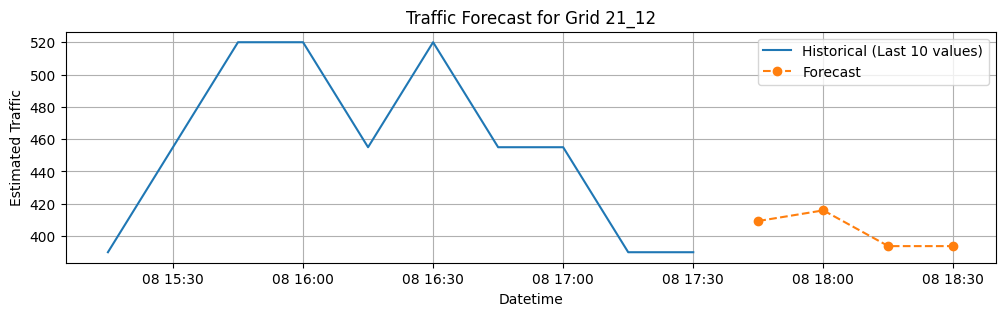

/tmp/ipykernel_1649761/2801794740.py:28: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  future_datetimes = pd.date_range(
/tmp/ipykernel_1649761/2801794740.py:70: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '679.0892086611668' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  future.loc[i, f'l{lag}'] = combined_traffic[current_idx - lag]
/tmp/ipykernel_1649761/2801794740.py:70: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '679.0892086611668' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  future.loc[i, f'l{lag}'] = combined_traffic[current_idx - lag]
/tmp/ipykernel_1649761/2801794740.py:70: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a futu

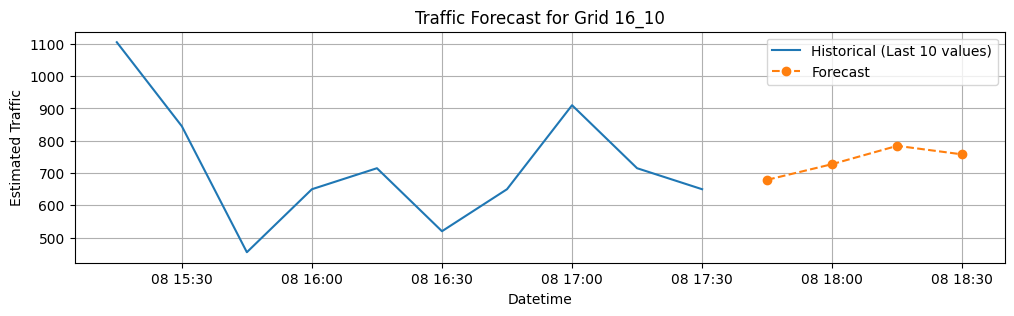

/tmp/ipykernel_1649761/2801794740.py:28: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  future_datetimes = pd.date_range(
/tmp/ipykernel_1649761/2801794740.py:70: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '234.4257328435492' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  future.loc[i, f'l{lag}'] = combined_traffic[current_idx - lag]
/tmp/ipykernel_1649761/2801794740.py:70: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '234.4257328435492' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  future.loc[i, f'l{lag}'] = combined_traffic[current_idx - lag]
/tmp/ipykernel_1649761/2801794740.py:70: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a futu

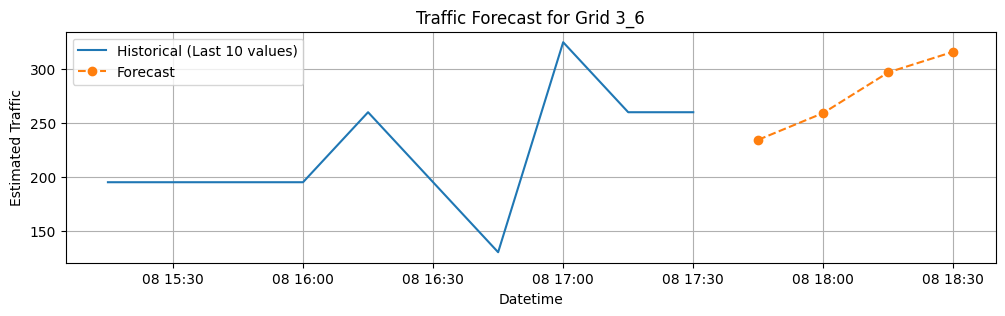

/tmp/ipykernel_1649761/2801794740.py:28: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  future_datetimes = pd.date_range(
/tmp/ipykernel_1649761/2801794740.py:70: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '371.1080696337956' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  future.loc[i, f'l{lag}'] = combined_traffic[current_idx - lag]
/tmp/ipykernel_1649761/2801794740.py:70: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '371.1080696337956' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  future.loc[i, f'l{lag}'] = combined_traffic[current_idx - lag]
/tmp/ipykernel_1649761/2801794740.py:70: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a futu

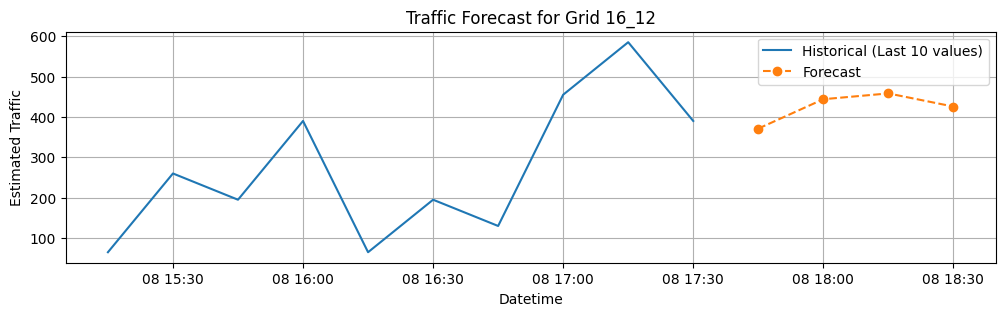

/tmp/ipykernel_1649761/2801794740.py:28: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  future_datetimes = pd.date_range(
/tmp/ipykernel_1649761/2801794740.py:70: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9810.76459560507' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  future.loc[i, f'l{lag}'] = combined_traffic[current_idx - lag]
/tmp/ipykernel_1649761/2801794740.py:70: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9810.76459560507' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  future.loc[i, f'l{lag}'] = combined_traffic[current_idx - lag]
/tmp/ipykernel_1649761/2801794740.py:70: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future

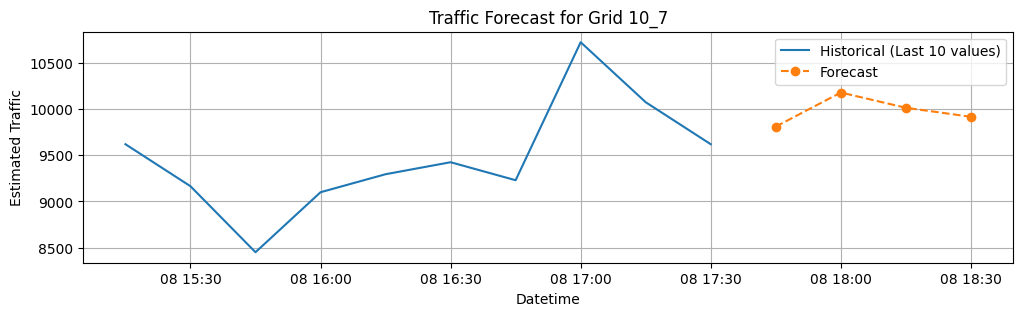

In [58]:
for grid in selected_grids[:5]:
    forecast_results = forecast_catboost(
        grid_id=grid,
        test_set=traffic_data,
        grid_features=grid_features,
        model=catboost,
        features=features,
        n_forecast=4, # one hour forecasting horizon
        plot=True
    )

In [59]:
volatilities_catboost = []
for grid in selected_grids:
    forecast_results = forecast_catboost(
        grid_id=grid,
        test_set=traffic_data,
        grid_features=grid_features,
        model=catboost,
        features=features,
        n_forecast=4, # one hour forecasting horizon
        plot=False
    )
    forecasted_values = forecast_results['estimated_traffic'].values
    st_dev = np.std(forecasted_values)
    volatilities_catboost.append(st_dev)

/tmp/ipykernel_1649761/2801794740.py:28: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  future_datetimes = pd.date_range(
/tmp/ipykernel_1649761/2801794740.py:70: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '409.32214469648716' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  future.loc[i, f'l{lag}'] = combined_traffic[current_idx - lag]
/tmp/ipykernel_1649761/2801794740.py:70: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '409.32214469648716' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  future.loc[i, f'l{lag}'] = combined_traffic[current_idx - lag]
/tmp/ipykernel_1649761/2801794740.py:70: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a fu

In [60]:
def forecast_lightgbm(grid_id, test_set, grid_features, model, features, n_forecast, plot=False):
    """
    Forecast future traffic values for a specific grid_id using the trained CatBoost model.
    
    Parameters:
        grid_id (str/int): Grid ID to forecast.
        test_set (pd.DataFrame): Test dataset with historical data including necessary features.
        grid_features (pd.DataFrame): Features associated with each grid_id.
        model (CatBoostRegressor): Trained CatBoost model.
        features (list): List of feature names used by the model.
        n_forecast (int): Number of steps to forecast (each step is 15 minutes).
        plot (bool): Whether to plot the forecast.
        
    Returns:
        pd.DataFrame: Forecasted values with datetime and estimated_traffic.
    """
    # Filter test_set for the grid_id and get last datetime
    #test_set['datetime'] = pd.to_datetime(test_set['datetime'])
    grid_test = test_set[test_set['grid_id'] == grid_id].sort_values('datetime')
    if grid_test.empty:
        raise ValueError(f"No data found for grid_id {grid_id} in test_set")
    
    last_row = grid_test.iloc[-1]
    last_datetime = last_row['datetime']
    #last_datetime = pd.to_datetime(last_row['datetime'])
    
    # Generate future datetimes (15-minute intervals)
    future_datetimes = pd.date_range(
        start=last_datetime + pd.Timedelta(minutes=15),
        periods=n_forecast,
        freq='15T'
    )
    
    # Create future dataframe
    future = pd.DataFrame({'datetime': future_datetimes, 'grid_id': grid_id})
    
    # Merge grid features
    future = future.merge(grid_features, on='grid_id', how='left')
    
    # Generate time features
    future['hour'] = future['datetime'].dt.hour
    future['day_of_week'] = future['datetime'].dt.dayofweek
    future['is_weekend'] = future['day_of_week'].isin([5, 6]).astype(int)
    future['quarter'] = future['datetime'].dt.quarter
    future['day_of_month'] = future['datetime'].dt.day
    future['week_of_year'] = future['datetime'].dt.isocalendar().week
    
    # Encode cyclical features
    future = encode_cyclical(future, 'hour', 24)
    future = encode_cyclical(future, 'day_of_week', 7)
    future = encode_cyclical(future, 'day_of_month', 31)
    for col in categorial_features:
        future[col] = future[col].astype('category')
    # Initialize lag columns with -1
    lag_columns = [f'l{lag}' for lag in range(1, 6)] + [f'lag_{hours}h' for hours in [24, 48, 72]]
    for col in lag_columns:
        future[col] = -1
    
    # Extract historical traffic values
    historical_traffic = grid_test[['datetime', 'estimated_traffic']].copy()
    combined_traffic = historical_traffic['estimated_traffic'].tolist()
    
    # Autoregressive forecasting
    for i in range(n_forecast):
        # Update lag features for the current step
        current_idx = len(historical_traffic) + i
        
        # Lags 1-5
        for lag in range(1, 6):
            if current_idx - lag >= 0:
                future.loc[i, f'l{lag}'] = combined_traffic[current_idx - lag]
        
        # Time-based lags (24h, 48h, 72h)
        for hours in [24, 48, 72]:
            lag_rows = hours * 4  # 4 rows per hour (15-minute intervals)
            if current_idx - lag_rows >= 0:
                future.loc[i, f'lag_{hours}h'] = combined_traffic[current_idx - lag_rows]
        
        # Predict current step
        X = future.loc[i:i][features]
        pred = model.predict(X)[0]
        future.loc[i, 'estimated_traffic'] = pred
        combined_traffic.append(pred)
    
    # Prepare results
    forecast_df = future[['datetime', 'estimated_traffic']]
    
    # Plot
    if plot:
        plt.figure(figsize=(12, 3))
        
        # Plot last 10 historical values
        plt.plot(historical_traffic['datetime'].tail(10), 
                historical_traffic['estimated_traffic'].tail(10), 
                label='Historical (Last 10 values)')
        
        # Plot forecast
        plt.plot(forecast_df['datetime'], 
                forecast_df['estimated_traffic'], 
                label='Forecast', 
                linestyle='--',
                marker='o')
        
        plt.title(f'Traffic Forecast for Grid {grid_id}')
        plt.xlabel('Datetime')
        plt.ylabel('Estimated Traffic')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    return forecast_df

In [61]:
lightgbm = lgb.Booster(model_file='LightGBM_final.txt')

/tmp/ipykernel_1649761/2870289320.py:28: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  future_datetimes = pd.date_range(
/tmp/ipykernel_1649761/2870289320.py:71: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '405.5289549517065' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  future.loc[i, f'l{lag}'] = combined_traffic[current_idx - lag]
/tmp/ipykernel_1649761/2870289320.py:71: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '405.5289549517065' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  future.loc[i, f'l{lag}'] = combined_traffic[current_idx - lag]
/tmp/ipykernel_1649761/2870289320.py:71: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a futu

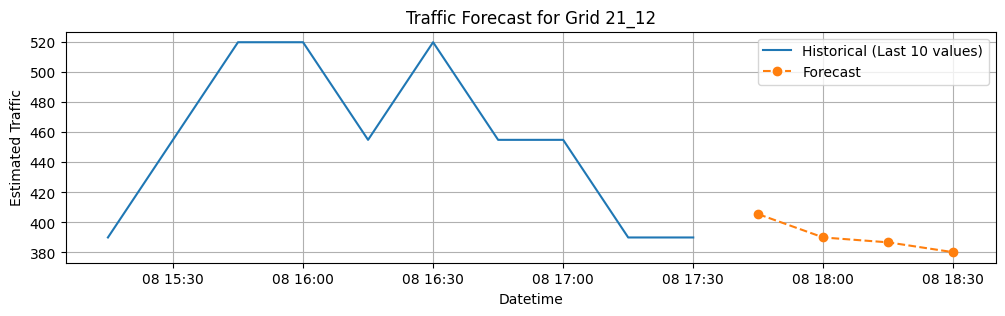

/tmp/ipykernel_1649761/2870289320.py:28: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  future_datetimes = pd.date_range(
/tmp/ipykernel_1649761/2870289320.py:71: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '699.1454738455399' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  future.loc[i, f'l{lag}'] = combined_traffic[current_idx - lag]
/tmp/ipykernel_1649761/2870289320.py:71: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '699.1454738455399' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  future.loc[i, f'l{lag}'] = combined_traffic[current_idx - lag]
/tmp/ipykernel_1649761/2870289320.py:71: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a futu

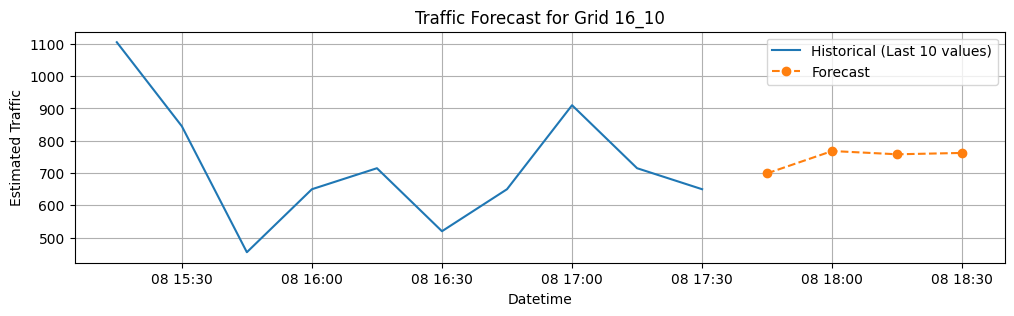

/tmp/ipykernel_1649761/2870289320.py:28: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  future_datetimes = pd.date_range(
/tmp/ipykernel_1649761/2870289320.py:71: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '261.2155696907594' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  future.loc[i, f'l{lag}'] = combined_traffic[current_idx - lag]
/tmp/ipykernel_1649761/2870289320.py:71: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '261.2155696907594' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  future.loc[i, f'l{lag}'] = combined_traffic[current_idx - lag]
/tmp/ipykernel_1649761/2870289320.py:71: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a futu

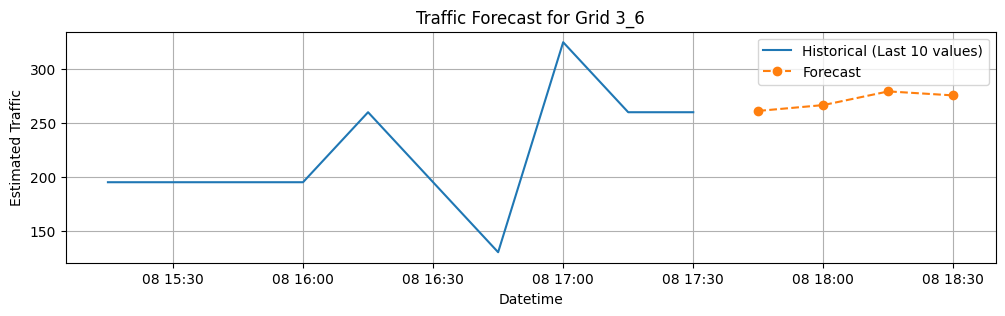

/tmp/ipykernel_1649761/2870289320.py:28: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  future_datetimes = pd.date_range(
/tmp/ipykernel_1649761/2870289320.py:71: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '396.9572343018141' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  future.loc[i, f'l{lag}'] = combined_traffic[current_idx - lag]
/tmp/ipykernel_1649761/2870289320.py:71: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '396.9572343018141' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  future.loc[i, f'l{lag}'] = combined_traffic[current_idx - lag]
/tmp/ipykernel_1649761/2870289320.py:71: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a futu

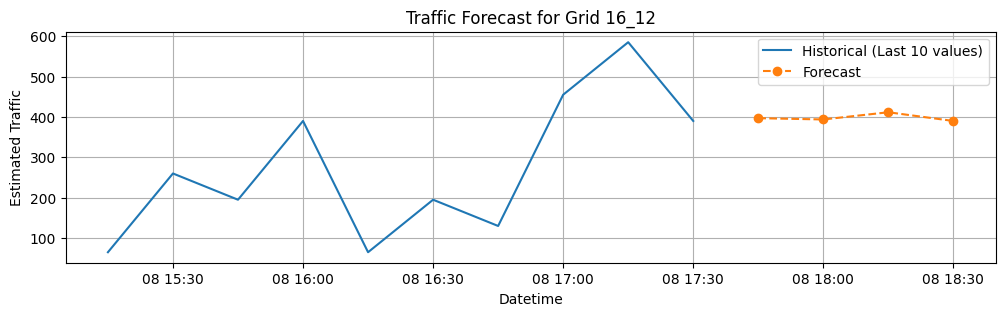

/tmp/ipykernel_1649761/2870289320.py:28: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  future_datetimes = pd.date_range(
/tmp/ipykernel_1649761/2870289320.py:71: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '10015.27890081937' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  future.loc[i, f'l{lag}'] = combined_traffic[current_idx - lag]
/tmp/ipykernel_1649761/2870289320.py:71: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '10015.27890081937' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  future.loc[i, f'l{lag}'] = combined_traffic[current_idx - lag]
/tmp/ipykernel_1649761/2870289320.py:71: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a futu

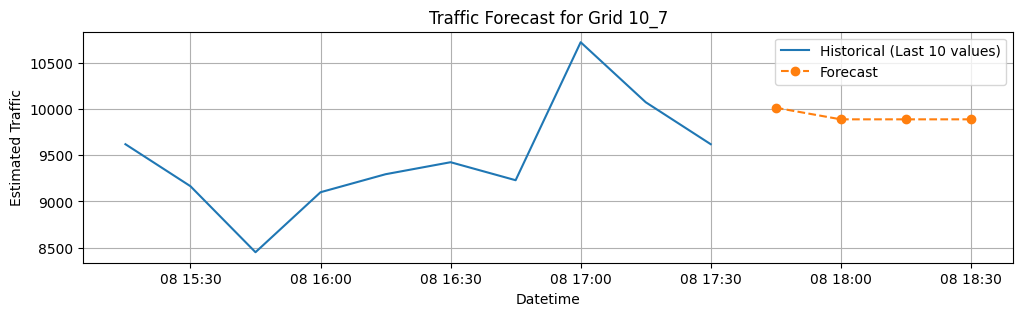

In [62]:
for grid in selected_grids[:5]:
    forecast_results = forecast_lightgbm(
        grid_id=grid,
        test_set=traffic_data,
        grid_features=grid_features,
        model=lightgbm,
        features=features,
        n_forecast=4, # one hour forecasting horizon
        plot=True
    )

In [63]:
volatilities_lightgbm = []
for grid in selected_grids:
    forecast_results = forecast_lightgbm(
        grid_id=grid,
        test_set=traffic_data,
        grid_features=grid_features,
        model=lightgbm,
        features=features,
        n_forecast=4, # one hour forecasting horizon
        plot=False
    )
    forecasted_values = forecast_results['estimated_traffic'].values
    st_dev = np.std(forecasted_values)
    volatilities_lightgbm.append(st_dev)

/tmp/ipykernel_1649761/2870289320.py:28: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  future_datetimes = pd.date_range(
/tmp/ipykernel_1649761/2870289320.py:71: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '405.5289549517065' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  future.loc[i, f'l{lag}'] = combined_traffic[current_idx - lag]
/tmp/ipykernel_1649761/2870289320.py:71: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '405.5289549517065' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  future.loc[i, f'l{lag}'] = combined_traffic[current_idx - lag]
/tmp/ipykernel_1649761/2870289320.py:71: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a futu

In [75]:
volatilities_catboost = [float(v) for v in volatilities_catboost]

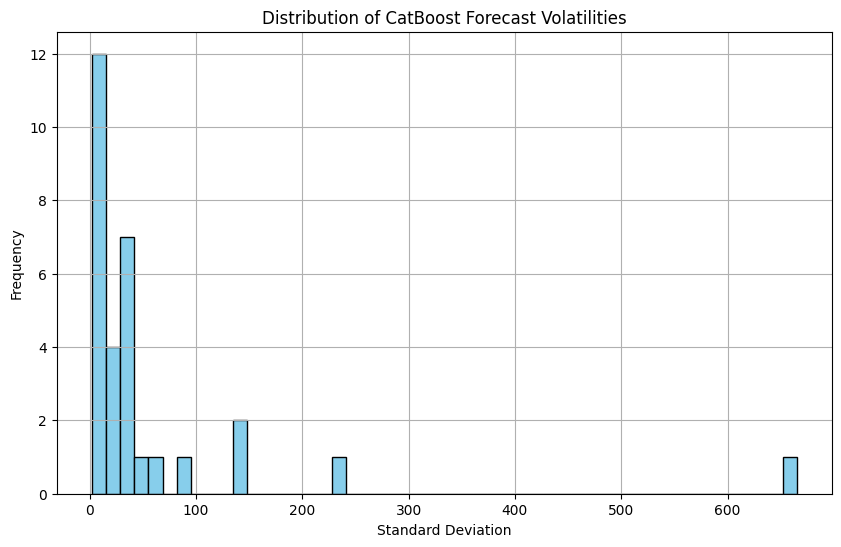

In [94]:
plt.figure(figsize=(10, 6))
plt.hist(volatilities_catboost, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of CatBoost Forecast Volatilities')
plt.xlabel('Standard Deviation')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig('volatility_distribution_catboost.png')
plt.show()

In [74]:
volatilities_lightgbm = [float(v) for v in volatilities_lightgbm]

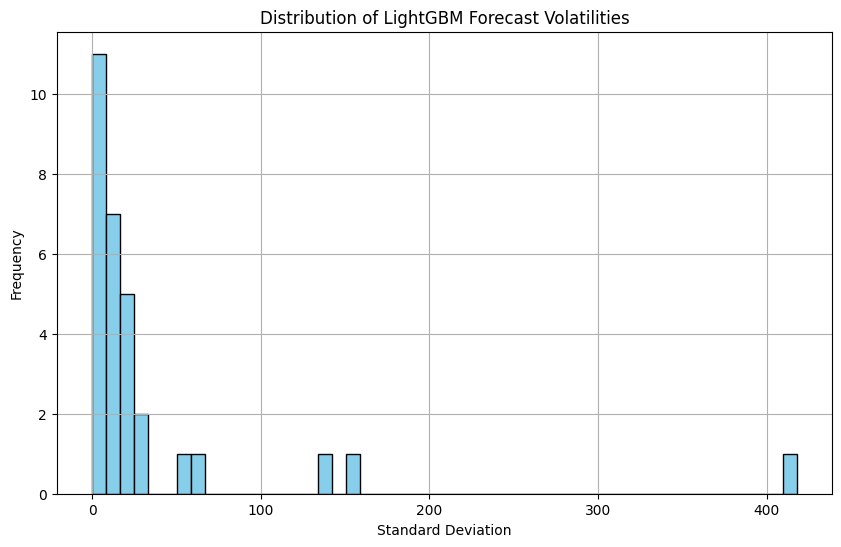

In [95]:
plt.figure(figsize=(10, 6))
plt.hist(volatilities_lightgbm, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of LightGBM Forecast Volatilities')
plt.xlabel('Standard Deviation')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig('volatility_distribution_lightgbm.png')
plt.show()